# DuckDB Analytics Notebook

Explore the CCT Environmental Sensors dataset loaded into DuckDB star schema.

## Database Structure

- **dim_station**: Station master data (11 stations)
- **fact_measurement**: Time-series measurements (2.9M+ rows)
- **Views**: Pre-built analytical views for common queries

## Data Sources

- **Wind Data**: 2016-2020 (5 years) - wind_speed, wind_direction
- **Air Quality Data**: 2019-2022 (4 years) - NO₂, O₃, PM10, PM2.5, SO₂
- **Shared Stations**: 7 stations have both wind and air quality data

In [5]:
# Import required libraries
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("📚 Libraries loaded successfully")

📚 Libraries loaded successfully


In [6]:
# Connect to DuckDB
duckdb_path = Path("../data/duckdb/cct_env.duckdb")
con = duckdb.connect(str(duckdb_path))

print(f"🔗 Connected to: {duckdb_path}")
print(f"📊 File size: {duckdb_path.stat().st_size / 1024 / 1024:.1f} MB")

🔗 Connected to: ../data/duckdb/cct_env.duckdb
📊 File size: 414.5 MB


## 1. Database Overview

In [7]:
# Database summary
print("📊 DATABASE SUMMARY")
print("=" * 40)

# Table counts
tables = con.execute("""
    SELECT table_name, table_type
    FROM information_schema.tables
    WHERE table_schema = 'main'
    ORDER BY table_name
""").fetchdf()

print(f"\n🏢 Tables ({len(tables)}):")
for _, row in tables.iterrows():
    if row['table_name'].startswith('dim_') or row['table_name'].startswith('fact_'):
        count = con.execute(f"SELECT COUNT(*) FROM {row['table_name']}").fetchone()[0]
        print(f"   - {row['table_name']}: {count:,} rows")

# Views
views = con.execute("""
    SELECT table_name
    FROM information_schema.views
    WHERE table_schema = 'main' AND table_name LIKE 'v_%'
    ORDER BY table_name
""").fetchdf()

print(f"\n📊 Views ({len(views)}):")
for _, row in views.iterrows():
    print(f"   - {row['table_name']}")

📊 DATABASE SUMMARY

🏢 Tables (5):
   - dim_station: 11 rows
   - fact_measurement: 2,963,373 rows

📊 Views (3):
   - v_data_quality_summary
   - v_measurements
   - v_wind_data


## 2. Station Dimension Analysis

In [8]:
# Station overview
stations = con.execute("""
    SELECT 
        station_pk,
        station_code,
        station_name,
        location_type
    FROM dim_station
    ORDER BY station_pk
""").fetchdf()

print("🏢 STATION DIRECTORY")
print("=" * 50)
for _, row in stations.iterrows():
    print(f"   {row['station_pk']:2d}. {row['station_code']} - {row['station_name']}")
    print(f"       Type: {row['location_type']}")

display(stations)

🏢 STATION DIRECTORY
    1. ATLAN001 - Atlantis AQM Site
       Type: AQM
    2. BELLV001 - Bellville South AQM Site
       Type: AQM
    3. BOTHA001 - Bothasig AQM Site
       Type: AQM
    4. GOODW001 - Goodwood AQM Station
       Type: AQM
    5. KHAYE001 - Khayelitsha AQM Site
       Type: AQM
    6. SOMER001 - Somerset West AQM Site
       Type: AQM
    7. TABLE001 - Tableview AQM Site
       Type: AQM
    8. FORES001 - Foreshore AQM Site
       Type: AQM
    9. MOLTE001 - Molteno AQM Site
       Type: AQM
   10. PLATT001 - Plattekloof AQM Site
       Type: AQM
   11. WALLA001 - Wallacedene AQM Site
       Type: AQM


,station_pk,station_code,station_name,location_type
0,1,ATLAN001,Atlantis AQM Site,AQM
1,2,BELLV001,Bellville South AQM Site,AQM
2,3,BOTHA001,Bothasig AQM Site,AQM
3,4,GOODW001,Goodwood AQM Station,AQM
4,5,KHAYE001,Khayelitsha AQM Site,AQM
5,6,SOMER001,Somerset West AQM Site,AQM
6,7,TABLE001,Tableview AQM Site,AQM
7,8,FORES001,Foreshore AQM Site,AQM
8,9,MOLTE001,Molteno AQM Site,AQM
9,10,PLATT001,Plattekloof AQM Site,AQM


## 3. Data Coverage Analysis

In [9]:
# Data coverage by source and metric
coverage = con.execute("""
    SELECT 
        source,
        metric,
        COUNT(*) as total_measurements,
        COUNT(DISTINCT station_fk) as stations,
        MIN(timestamp) as earliest_date,
        MAX(timestamp) as latest_date,
        COUNT(DISTINCT DATE_TRUNC('day', timestamp)) as days_covered,
        COUNT(CASE WHEN quality_flag = 'VALID' THEN 1 END) as valid_measurements,
        ROUND(COUNT(CASE WHEN quality_flag = 'VALID' THEN 1 END) * 100.0 / COUNT(*), 1) as valid_pct
    FROM fact_measurement
    GROUP BY source, metric
    ORDER BY source, metric
""").fetchdf()

print("📊 DATA COVERAGE BY METRIC")
print("=" * 80)
print(f"{'Source':<12} {'Metric':<15} {'Measurements':<12} {'Stations':<8} {'Period':<20} {'Valid %':<8}")
print("-" * 80)

for _, row in coverage.iterrows():
    period = f"{row['earliest_date'].strftime('%Y-%m')} to {row['latest_date'].strftime('%Y-%m')}"
    print(f"{row['source']:<12} {row['metric']:<15} {row['total_measurements']:<12,} {row['stations']:<8} {period:<20} {row['valid_pct']:<8}%")

display(coverage)

📊 DATA COVERAGE BY METRIC
Source       Metric          Measurements Stations Period               Valid % 
--------------------------------------------------------------------------------
air_quality  no2             205,588      10       2019-01 to 2022-06   48.2    %
air_quality  o3              131,069      7        2019-01 to 2022-06   32.9    %
air_quality  pm10            1,982,236    8        2019-01 to 2022-06   60.6    %
air_quality  pm25            135,672      8        2020-01 to 2022-06   62.8    %
air_quality  so2             266,888      9        2019-01 to 2022-06   55.3    %
wind         wind_direction  120,960      7        2016-01 to 2020-12   66.0    %
wind         wind_speed      120,960      7        2016-01 to 2020-12   66.5    %


,source,metric,total_measurements,stations,earliest_date,latest_date,days_covered,valid_measurements,valid_pct
0,air_quality,no2,205588,10,2019-01-01,2022-06-30 23:00:00,1277,99183,48.2
1,air_quality,o3,131069,7,2019-01-01,2022-06-30 23:00:00,911,43085,32.9
2,air_quality,pm10,1982236,8,2019-01-01,2022-06-30 23:59:00,1277,1200868,60.6
3,air_quality,pm25,135672,8,2020-01-01,2022-06-30 23:00:00,912,85267,62.8
4,air_quality,so2,266888,9,2019-01-01,2022-06-30 23:00:00,1277,147607,55.3
5,wind,wind_direction,120960,7,2016-01-01,2020-12-12 23:00:00,720,79788,66.0
6,wind,wind_speed,120960,7,2016-01-01,2020-12-12 23:00:00,720,80449,66.5


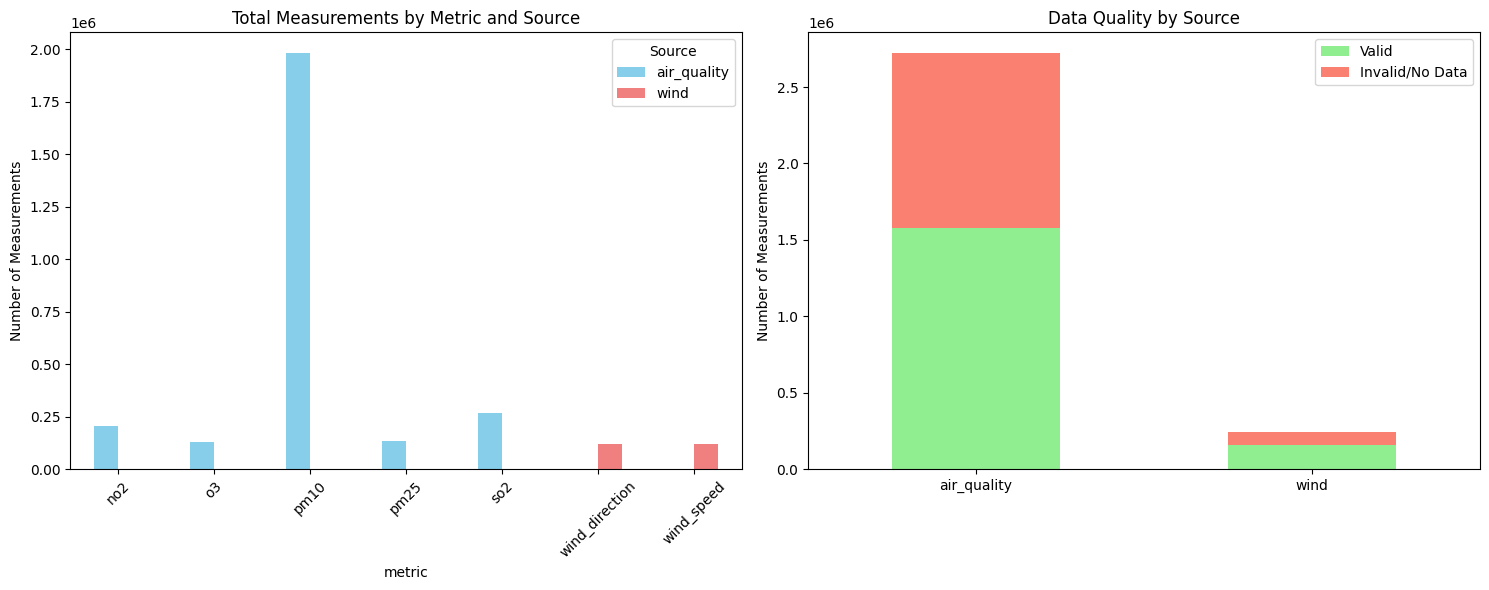

In [10]:
# Visualize data coverage
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Measurements by metric
coverage_pivot = coverage.pivot_table(values='total_measurements', index='metric', columns='source', fill_value=0)
coverage_pivot.plot(kind='bar', ax=ax1, color=['skyblue', 'lightcoral'])
ax1.set_title('Total Measurements by Metric and Source')
ax1.set_ylabel('Number of Measurements')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Source')

# Data quality by source
quality_summary = coverage.groupby('source').agg({
    'total_measurements': 'sum',
    'valid_measurements': 'sum'
}).reset_index()
quality_summary['invalid_measurements'] = quality_summary['total_measurements'] - quality_summary['valid_measurements']

quality_summary[['valid_measurements', 'invalid_measurements']].plot(
    kind='bar', stacked=True, ax=ax2, color=['lightgreen', 'salmon']
)
ax2.set_title('Data Quality by Source')
ax2.set_ylabel('Number of Measurements')
ax2.set_xticklabels(quality_summary['source'], rotation=0)
ax2.legend(['Valid', 'Invalid/No Data'])

plt.tight_layout()
plt.show()

## 4. Time Series Analysis

<Figure size 1500x600 with 0 Axes>

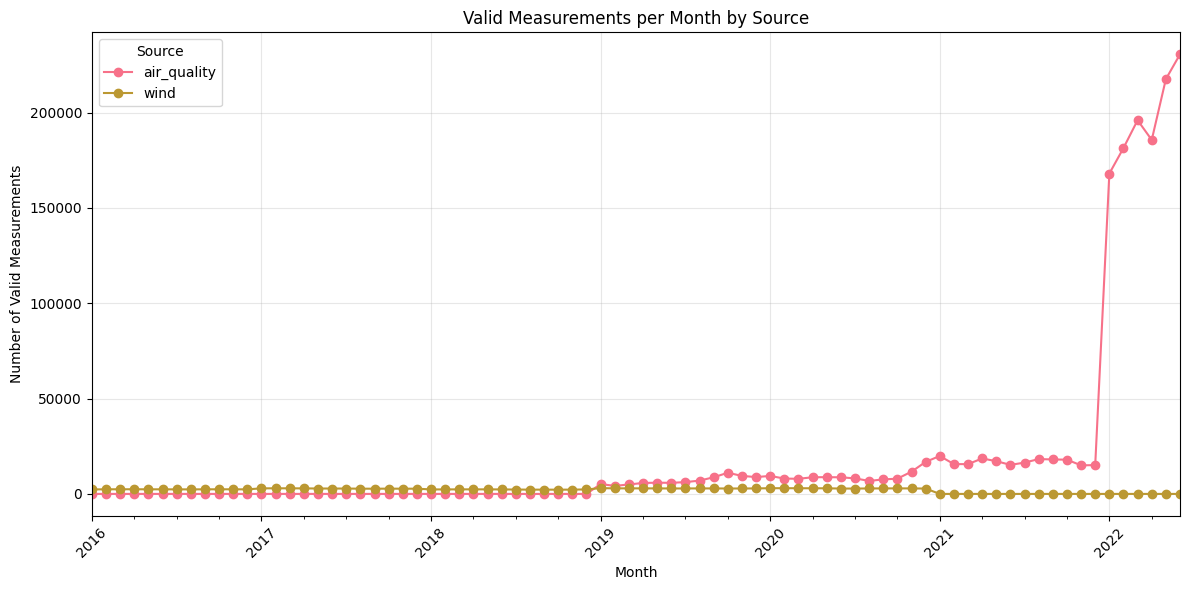

📈 Data spans 78 months from 2016-01 to 2022-06


In [11]:
# Monthly measurement trends
monthly_trends = con.execute("""
    SELECT 
        DATE_TRUNC('month', timestamp) as month,
        source,
        COUNT(*) as measurements
    FROM fact_measurement
    WHERE quality_flag = 'VALID'
    GROUP BY DATE_TRUNC('month', timestamp), source
    ORDER BY month, source
""").fetchdf()

# Pivot for plotting
monthly_pivot = monthly_trends.pivot_table(
    values='measurements', 
    index='month', 
    columns='source', 
    fill_value=0
)

plt.figure(figsize=(15, 6))
monthly_pivot.plot(kind='line', marker='o')
plt.title('Valid Measurements per Month by Source')
plt.xlabel('Month')
plt.ylabel('Number of Valid Measurements')
plt.legend(title='Source')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"📈 Data spans {len(monthly_pivot)} months from {monthly_pivot.index.min().strftime('%Y-%m')} to {monthly_pivot.index.max().strftime('%Y-%m')}")

## 5. Air Quality Analysis

🌬️ AIR QUALITY STATISTICS


,station_name,metric,unit,measurements,avg_value,min_value,max_value,std_value
0,Atlantis AQM Site,o3,ug/m3(S),15451,42.64,-1.0,159.0,18.80
1,Atlantis AQM Site,so2,ug/m3(S),9424,5.53,-1.0,103.0,7.11
2,Bellville South AQM Site,no2,ug/m3(S),10543,12.13,0.0,145.0,12.80
3,Bellville South AQM Site,pm10,ug/m3(S),263280,31.71,0.0,775.0,29.48
4,Bellville South AQM Site,pm25,ug/m3(S),13030,12.58,0.0,482.2,14.34
5,Bellville South AQM Site,so2,ug/m3(S),22792,4.70,0.0,147.0,7.73
6,Bothasig AQM Site,no2,ug/m3(S),4911,14.24,0.0,273.0,17.94
7,Bothasig AQM Site,so2,ug/m3(S),11665,2.53,0.0,241.0,2.86
8,Foreshore AQM Site,no2,ug/m3(S),8514,24.81,0.0,186.0,24.25
9,Foreshore AQM Site,pm10,ug/m3(S),191080,33.32,0.0,842.0,30.07


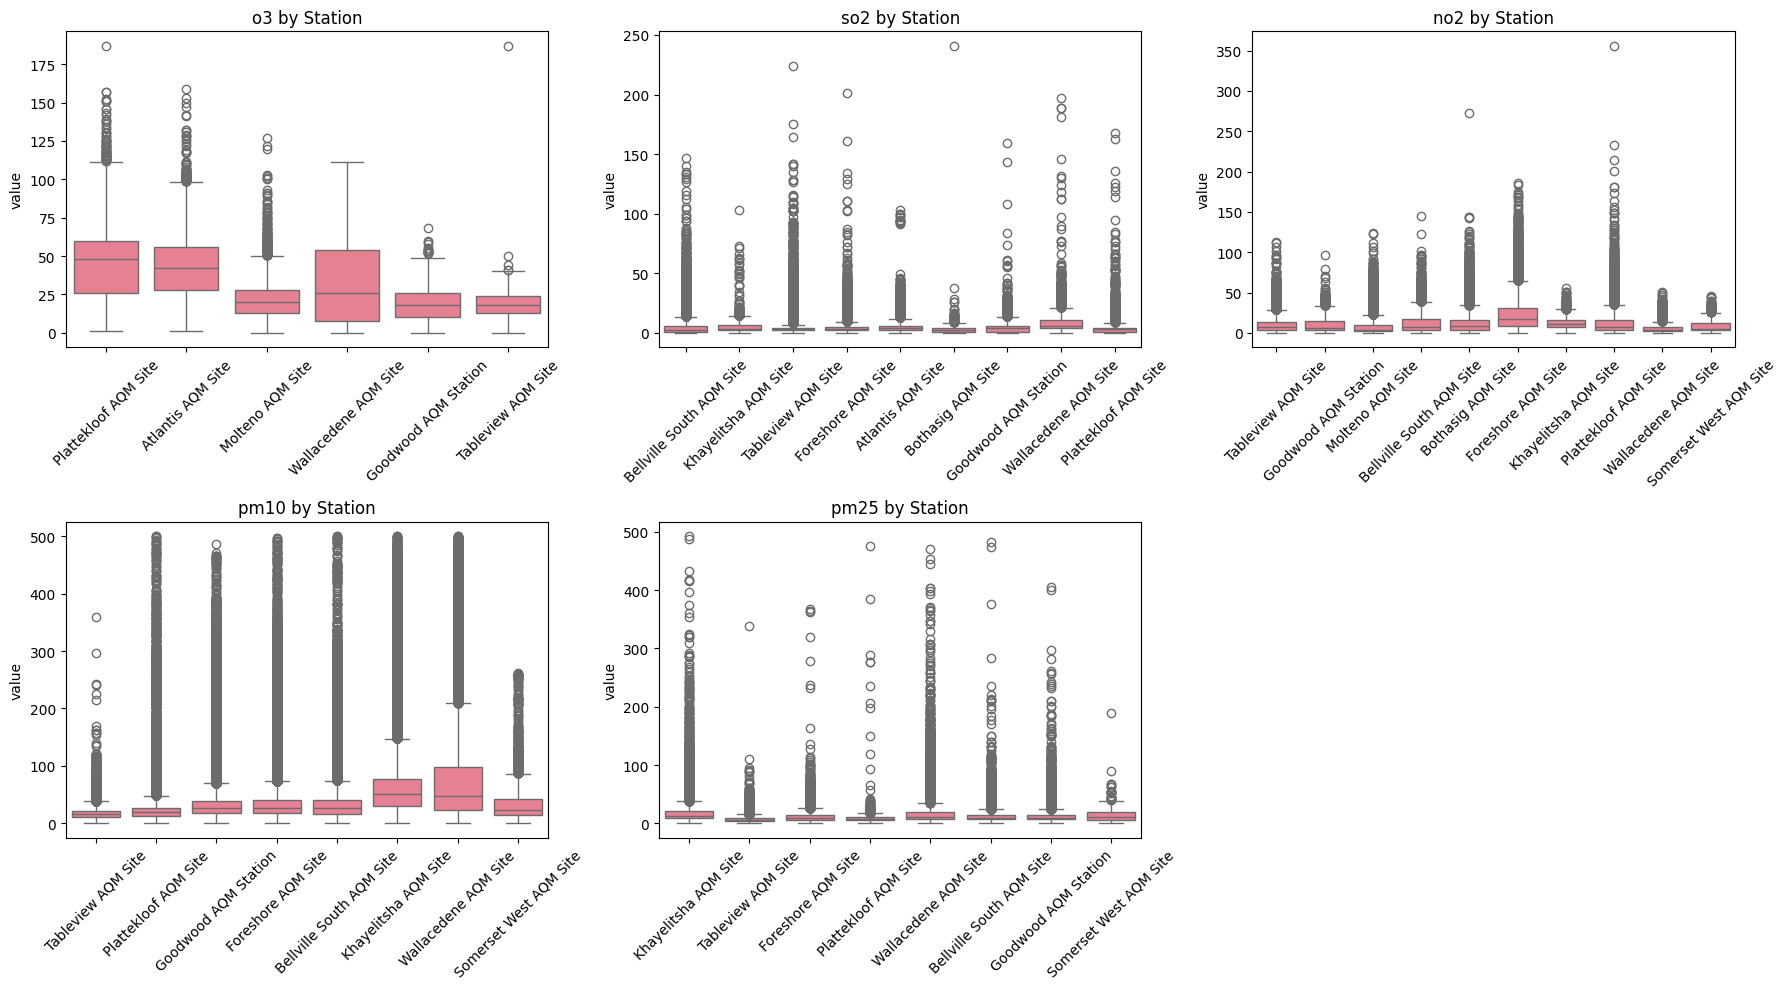

In [12]:
# Air quality statistics
air_quality_stats = con.execute("""
    SELECT 
        s.station_name,
        m.metric,
        m.unit,
        COUNT(*) as measurements,
        ROUND(AVG(m.value), 2) as avg_value,
        ROUND(MIN(m.value), 2) as min_value,
        ROUND(MAX(m.value), 2) as max_value,
        ROUND(STDDEV(m.value), 2) as std_value
    FROM fact_measurement m
    JOIN dim_station s ON m.station_fk = s.station_pk
    WHERE m.source = 'air_quality' AND m.quality_flag = 'VALID' AND m.value IS NOT NULL
    GROUP BY s.station_name, m.metric, m.unit
    ORDER BY s.station_name, m.metric
""").fetchdf()

print("🌬️ AIR QUALITY STATISTICS")
print("=" * 80)
display(air_quality_stats.head(10))

# Box plots for air quality metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

metrics = air_quality_stats['metric'].unique()
for i, metric in enumerate(metrics):
    if i < len(axes):
        metric_data = con.execute(f"""
            SELECT s.station_name, m.value
            FROM fact_measurement m
            JOIN dim_station s ON m.station_fk = s.station_pk
            WHERE m.metric = '{metric}' AND m.quality_flag = 'VALID' AND m.value IS NOT NULL
            AND m.value BETWEEN 0 AND 500  -- Remove extreme outliers
        """).fetchdf()
        
        if not metric_data.empty:
            sns.boxplot(data=metric_data, x='station_name', y='value', ax=axes[i])
            axes[i].set_title(f'{metric} by Station')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].set_xlabel('')

# Remove empty subplots
for i in range(len(metrics), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## 6. Wind Analysis

💨 WIND STATISTICS BY STATION


,station_name,measurements,avg_wind_speed,max_wind_speed,avg_wind_direction
0,Goodwood AQM Station,29404,11.16,37.6,239.9
1,Bothasig AQM Site,31878,3.77,13.1,191.7
2,Tableview AQM Site,32279,3.64,12.4,177.3
3,Atlantis AQM Site,16135,3.59,11.3,189.7
4,Somerset West AQM Site,23000,2.75,11.1,195.8
5,Bellville South AQM Site,18007,2.13,7.9,204.7
6,Khayelitsha AQM Site,9534,1.13,9.6,76.4


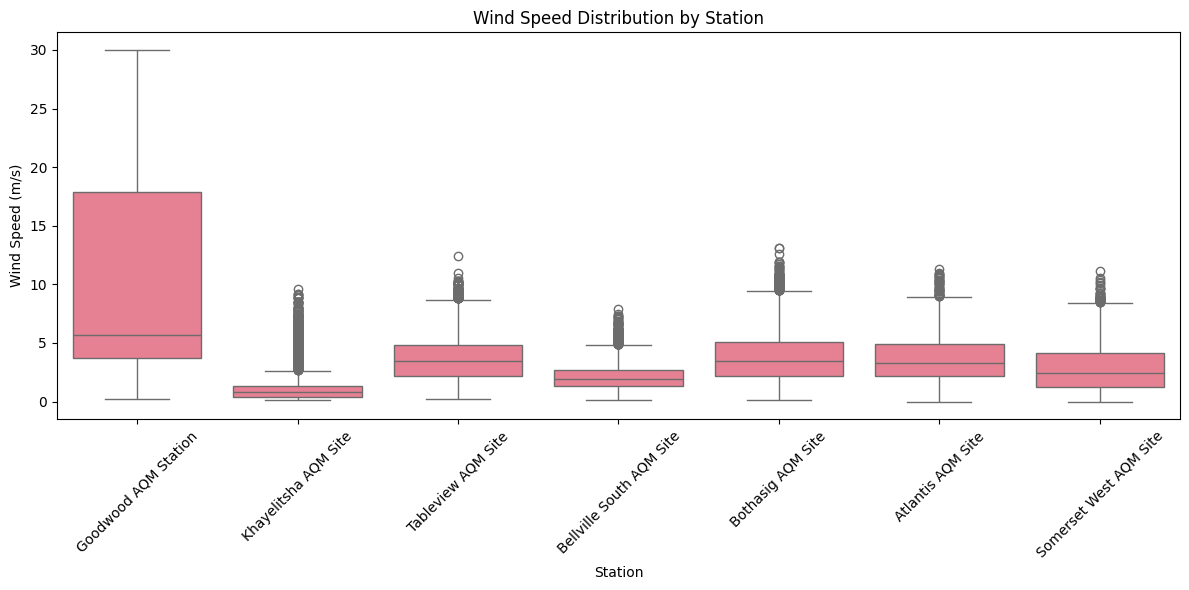

In [13]:
# Wind statistics
wind_stats = con.execute("""
    SELECT 
        s.station_name,
        COUNT(*) as measurements,
        ROUND(AVG(CASE WHEN m.metric = 'wind_speed' THEN m.value END), 2) as avg_wind_speed,
        ROUND(MAX(CASE WHEN m.metric = 'wind_speed' THEN m.value END), 2) as max_wind_speed,
        ROUND(AVG(CASE WHEN m.metric = 'wind_direction' THEN m.value END), 1) as avg_wind_direction
    FROM fact_measurement m
    JOIN dim_station s ON m.station_fk = s.station_pk
    WHERE m.source = 'wind' AND m.quality_flag = 'VALID' AND m.value IS NOT NULL
    GROUP BY s.station_name
    ORDER BY avg_wind_speed DESC
""").fetchdf()

print("💨 WIND STATISTICS BY STATION")
print("=" * 60)
display(wind_stats)

# Wind speed distribution
wind_data = con.execute("""
    SELECT 
        s.station_name,
        m.value as wind_speed
    FROM fact_measurement m
    JOIN dim_station s ON m.station_fk = s.station_pk
    WHERE m.metric = 'wind_speed' AND m.quality_flag = 'VALID' 
    AND m.value IS NOT NULL AND m.value BETWEEN 0 AND 30
""").fetchdf()

plt.figure(figsize=(12, 6))
sns.boxplot(data=wind_data, x='station_name', y='wind_speed')
plt.title('Wind Speed Distribution by Station')
plt.xlabel('Station')
plt.ylabel('Wind Speed (m/s)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Cross-Dataset Analysis (Shared Stations)

In [14]:
# Find stations with both wind and air quality data
shared_stations = con.execute("""
    SELECT 
        s.station_name,
        COUNT(DISTINCT m.source) as data_sources,
        COUNT(CASE WHEN m.source = 'wind' THEN 1 END) as wind_measurements,
        COUNT(CASE WHEN m.source = 'air_quality' THEN 1 END) as air_quality_measurements
    FROM fact_measurement m
    JOIN dim_station s ON m.station_fk = s.station_pk
    GROUP BY s.station_name
    HAVING COUNT(DISTINCT m.source) > 1
    ORDER BY wind_measurements DESC
""").fetchdf()

print(f"🔗 SHARED STATIONS ({len(shared_stations)} stations have both wind and air quality data)")
print("=" * 70)
display(shared_stations)

# Example correlation analysis for one shared station
if not shared_stations.empty:
    sample_station = shared_stations.iloc[0]['station_name']
    
    correlation_data = con.execute(f"""
        WITH daily_averages AS (
            SELECT 
                DATE_TRUNC('day', m.timestamp) as date,
                AVG(CASE WHEN m.metric = 'wind_speed' THEN m.value END) as avg_wind_speed,
                AVG(CASE WHEN m.metric = 'no2' THEN m.value END) as avg_no2
            FROM fact_measurement m
            JOIN dim_station s ON m.station_fk = s.station_pk
            WHERE s.station_name = '{sample_station}'
            AND m.quality_flag = 'VALID' AND m.value IS NOT NULL
            GROUP BY DATE_TRUNC('day', m.timestamp)
        )
        SELECT date, avg_wind_speed, avg_no2
        FROM daily_averages
        WHERE avg_wind_speed IS NOT NULL AND avg_no2 IS NOT NULL
        ORDER BY date
    """).fetchdf()
    
    if not correlation_data.empty and len(correlation_data) > 10:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.scatter(correlation_data['avg_wind_speed'], correlation_data['avg_no2'], alpha=0.6)
        plt.xlabel('Average Wind Speed (m/s)')
        plt.ylabel('Average NO₂ (μg/m³)')
        plt.title(f'Wind Speed vs NO₂ Correlation\n{sample_station}')
        
        # Calculate correlation
        corr = correlation_data['avg_wind_speed'].corr(correlation_data['avg_no2'])
        plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.subplot(1, 2, 2)
        correlation_data.set_index('date')[['avg_wind_speed', 'avg_no2']].plot(secondary_y='avg_no2')
        plt.title(f'Time Series: Wind Speed & NO₂\n{sample_station}')
        plt.xlabel('Date')
        
        plt.tight_layout()
        plt.show()
        
        print(f"📊 Found {len(correlation_data)} days with both wind and NO₂ data for {sample_station}")
        print(f"🔗 Wind Speed - NO₂ Correlation: {corr:.3f}")

🔗 SHARED STATIONS (7 stations have both wind and air quality data)


,station_name,data_sources,wind_measurements,air_quality_measurements
0,Khayelitsha AQM Site,2,34560,361298
1,Somerset West AQM Site,2,34560,269328
2,Bellville South AQM Site,2,34560,352585
3,Goodwood AQM Station,2,34560,374426
4,Atlantis AQM Site,2,34560,43729
5,Tableview AQM Site,2,34560,118179
6,Bothasig AQM Site,2,34560,48122


## 8. Data Quality Assessment

✅ DATA QUALITY ASSESSMENT


,source,metric,total_records,valid_records,nodata_records,null_values,valid_percentage
0,wind,wind_speed,120960,80449,40511,40511,66.5
1,wind,wind_direction,120960,79788,41172,41172,66.0
2,air_quality,pm25,135672,85267,50405,50405,62.8
3,air_quality,pm10,1982236,1200868,781368,781368,60.6
4,air_quality,so2,266888,147607,119281,119281,55.3
5,air_quality,no2,205588,99183,106405,106405,48.2
6,air_quality,o3,131069,43085,87984,87984,32.9


<Figure size 1400x800 with 0 Axes>

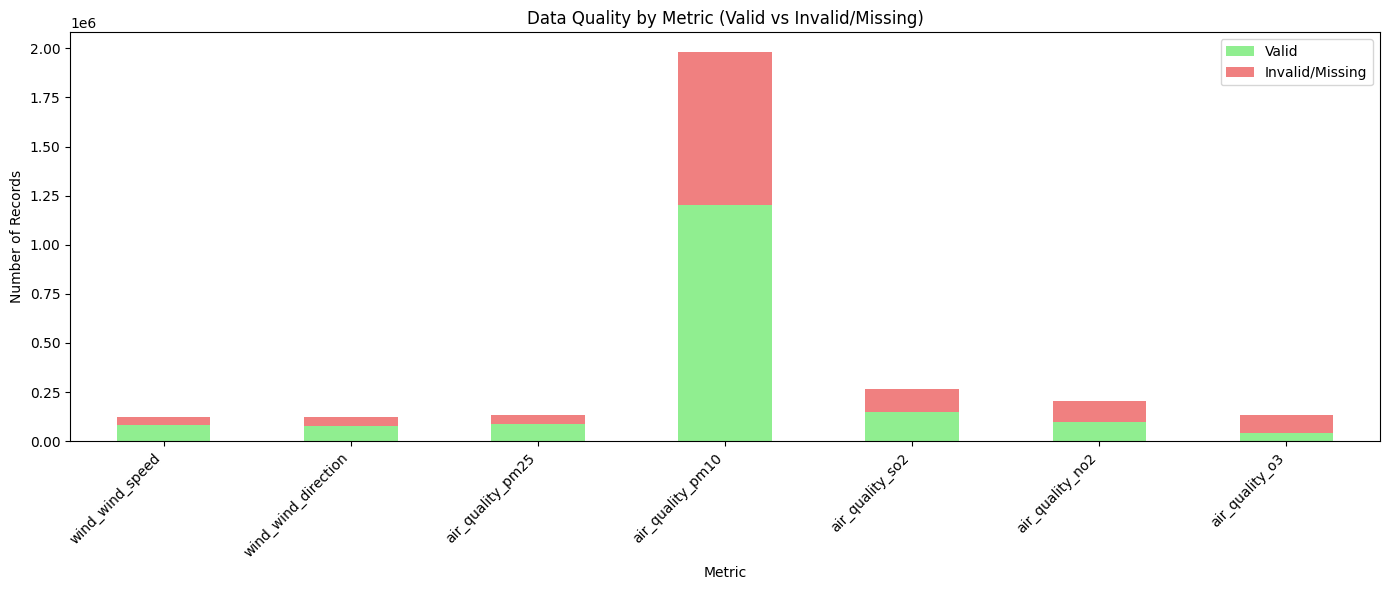


📊 OVERALL DATA QUALITY
   Total records: 2,963,373
   Valid records: 1,736,247
   Overall quality: 58.6%


In [15]:
# Data quality summary
quality_summary = con.execute("""
    SELECT 
        source,
        metric,
        COUNT(*) as total_records,
        COUNT(CASE WHEN quality_flag = 'VALID' THEN 1 END) as valid_records,
        COUNT(CASE WHEN quality_flag = 'NODATA' THEN 1 END) as nodata_records,
        COUNT(CASE WHEN value IS NULL THEN 1 END) as null_values,
        ROUND(COUNT(CASE WHEN quality_flag = 'VALID' THEN 1 END) * 100.0 / COUNT(*), 1) as valid_percentage
    FROM fact_measurement
    GROUP BY source, metric
    ORDER BY valid_percentage DESC
""").fetchdf()

print("✅ DATA QUALITY ASSESSMENT")
print("=" * 80)
display(quality_summary)

# Visualize data quality
plt.figure(figsize=(14, 8))

# Create a comprehensive quality visualization
quality_summary['invalid_records'] = quality_summary['total_records'] - quality_summary['valid_records']
quality_summary['metric_label'] = quality_summary['source'] + '_' + quality_summary['metric']

ax = quality_summary.set_index('metric_label')[['valid_records', 'invalid_records']].plot(
    kind='bar', stacked=True, color=['lightgreen', 'lightcoral'], figsize=(14, 6)
)

ax.set_title('Data Quality by Metric (Valid vs Invalid/Missing)')
ax.set_ylabel('Number of Records')
ax.set_xlabel('Metric')
ax.legend(['Valid', 'Invalid/Missing'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Overall quality statistics
total_records = quality_summary['total_records'].sum()
total_valid = quality_summary['valid_records'].sum()
overall_quality = (total_valid / total_records) * 100

print(f"\n📊 OVERALL DATA QUALITY")
print(f"   Total records: {total_records:,}")
print(f"   Valid records: {total_valid:,}")
print(f"   Overall quality: {overall_quality:.1f}%")

## 9. Custom Queries

Use this section to run your own analysis queries.

In [16]:
# Example custom query - Highest pollution days
custom_query = """
SELECT 
    DATE_TRUNC('day', m.timestamp) as date,
    s.station_name,
    m.metric,
    ROUND(AVG(m.value), 2) as avg_value,
    m.unit
FROM fact_measurement m
JOIN dim_station s ON m.station_fk = s.station_pk
WHERE m.source = 'air_quality' 
  AND m.quality_flag = 'VALID' 
  AND m.value IS NOT NULL
  AND m.metric IN ('no2', 'pm10')
GROUP BY DATE_TRUNC('day', m.timestamp), s.station_name, m.metric, m.unit
HAVING AVG(m.value) > 50  -- High pollution threshold
ORDER BY avg_value DESC
LIMIT 20
"""

result = con.execute(custom_query).fetchdf()
print("🚨 TOP 20 HIGH POLLUTION DAYS (NO₂ > 50 μg/m³ or PM10 > 50 μg/m³)")
print("=" * 80)
display(result)

🚨 TOP 20 HIGH POLLUTION DAYS (NO₂ > 50 μg/m³ or PM10 > 50 μg/m³)


,date,station_name,metric,avg_value,unit
0,2022-03-28,Khayelitsha AQM Site,pm10,649.14,ug/m3(S)
1,2021-07-25,Khayelitsha AQM Site,pm10,297.63,ug/m3(S)
2,2021-06-05,Wallacedene AQM Site,pm10,227.65,ug/m3(S)
3,2022-06-27,Wallacedene AQM Site,pm10,216.23,ug/m3(S)
4,2022-01-18,Wallacedene AQM Site,pm10,212.54,ug/m3(S)
5,2022-06-26,Wallacedene AQM Site,pm10,211.27,ug/m3(S)
6,2021-06-19,Khayelitsha AQM Site,pm10,209.83,ug/m3(S)
7,2021-07-25,Wallacedene AQM Site,pm10,207.21,ug/m3(S)
8,2021-07-24,Khayelitsha AQM Site,pm10,200.54,ug/m3(S)
9,2022-06-09,Khayelitsha AQM Site,pm10,199.82,ug/m3(S)


In [17]:
# Add your custom queries here
# Example:
# my_query = """
#     SELECT ...
#     FROM fact_measurement m
#     JOIN dim_station s ON m.station_fk = s.station_pk
#     WHERE ...
# """
# result = con.execute(my_query).fetchdf()
# display(result)

## 10. Cleanup

In [18]:
# Close database connection
con.close()
print("🔐 Database connection closed")
print("\n✅ Analysis complete!")
print("\n📋 Summary:")
print(f"   - Analyzed {total_records:,} environmental measurements")
print(f"   - Covered {len(stations)} monitoring stations")
print(f"   - Data spans wind (2016-2020) and air quality (2019-2022)")
print(f"   - Overall data quality: {overall_quality:.1f}%")
print(f"   - {len(shared_stations)} stations have both wind and air quality data")

🔐 Database connection closed

✅ Analysis complete!

📋 Summary:
   - Analyzed 2,963,373 environmental measurements
   - Covered 11 monitoring stations
   - Data spans wind (2016-2020) and air quality (2019-2022)
   - Overall data quality: 58.6%
   - 7 stations have both wind and air quality data
